# Exploratory Data Analysis (EDA)
## 1. Steps
### Load Data

This section is to import the necessary Python libraries and loading our main dataset which is the Performance - AI Usage Relation dataset.

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the datasets
df = pd.read_csv("data/perf_ai.csv")
df['Department'] = df['Department'].replace({'EXTC': 'Engineering', 'IT' : 'Business', 'Comp': 'CS'})
df

,StudentID,Department,CGPA,ChatGPT_Usage_Frequency_Per_Week,Average_Session_Duration_Minutes,Reason_For_Using_ChatGPT,Aptitude_Score
0,1,Engineering,7.55,2,16,saves time,4
1,2,Business,7.23,17,119,saves time,1
2,3,Engineering,8.11,13,62,no idea,2
3,4,Engineering,6.65,17,18,better answers,0
4,5,Business,5.42,1,91,no idea,0
...,...,...,...,...,...,...,...
232,233,Engineering,7.93,9,57,saves time,6
233,234,CS,7.70,2,28,better answers,7
234,235,CS,8.15,1,44,saves time,7
235,236,CS,8.42,0,33,saves time,8


### Data Cleaning

Here we preprocess the datasets to ensure it is ready for analysis. Firstly, We check for any null data that exist in the dataset. Then, we fix some of the error that we can find. One of it being when ChatGPT_Usage_Frequency_Per_Week is 0 but the Average_Session_Duration_Minutes is not zero and vice versa because it is not possible for this to happen.  

In [3]:
df.isnull().sum()

StudentID                           0
Department                          0
CGPA                                0
ChatGPT_Usage_Frequency_Per_Week    0
Average_Session_Duration_Minutes    0
Reason_For_Using_ChatGPT            0
Aptitude_Score                      0
dtype: int64

In [4]:
# If Duration exists, force Frequency to at least 1
mask1 = (df['ChatGPT_Usage_Frequency_Per_Week'] == 0) & (df['Average_Session_Duration_Minutes'] > 0)
df.loc[mask1, 'ChatGPT_Usage_Frequency_Per_Week'] = 1

# If Frequency exists, fill 0 Duration with the Median of non-zero durations
median_duration = df[df['Average_Session_Duration_Minutes'] > 0]['Average_Session_Duration_Minutes'].median()
print(median_duration)

mask2 = (df['ChatGPT_Usage_Frequency_Per_Week'] > 0) & (df['Average_Session_Duration_Minutes'] == 0)
df.loc[mask2, 'Average_Session_Duration_Minutes'] = median_duration


42.0


### Data Enrichment and Merging

Here we enrich the data through derivation of main dataset and merge it with new, external dataset to allow us understand more of the topic and analysis

**Derivation of Main Dataset:**
- Add and compute Total_AI_Time by multiplying ChatGPT_Usage_Frequency_Per_Week with Average_Session_Duration_Minutes to allow us to analyse student's usage of AI better
- Add and compute Avg_CGPA_by_Dept by getting the average of CGPA for each departments to allow us to see if different department's will have different performance
- Add and compute Relative_CGPA by subtracting Student's CGPA with Avg_CGPA_by_Dept to allow us to see if the student is doing better or worse than other people in the same department

**External Dataset Merging:**
- We rename some columns to allow for better understanding and variable calling
- Extract some columns such as Department, Avg_Stress_Level_Dept and Avg_Difficulty_Dept
- Merge the datasets together based on identical departments
- Allow us to analyse if Average Stress Level of each departments will effect the students' AI usage

#### Data Enrichment (Derived)

In [5]:
df['Total_AI_Time'] = df['ChatGPT_Usage_Frequency_Per_Week'] * df['Average_Session_Duration_Minutes']
df['Avg_CGPA_by_Dept'] = df.groupby('Department')['CGPA'].transform('mean')
df['Relative_CGPA'] = df['CGPA'] - df['Avg_CGPA_by_Dept']

#### Data Enrichment (External)

In [6]:
df_enrich=pd.read_csv("data/stud_performance.csv")
df_enrich = df_enrich.rename(columns={'Stress_Level (1-10)':'Avg_Stress_Level_Dept'}).reset_index()
df_enrich = df_enrich.rename(columns={'Total_Score':'Benchmark_CGPA'}).reset_index()
df_enrich = df_enrich[['Department', 'Avg_Stress_Level_Dept', 'Benchmark_CGPA']]
print(df_enrich.isnull().sum())

# Normalize Benchmark_CGPA to a 10-point CGPA scale
df_enrich['Benchmark_CGPA'] = df_enrich['Benchmark_CGPA'] / 9.5
df_enrich.head()

Department               0
Avg_Stress_Level_Dept    0
Benchmark_CGPA           0
dtype: int64


,Department,Avg_Stress_Level_Dept,Benchmark_CGPA
0,Mathematics,1,6.303842
1,Business,4,8.622842
2,Engineering,9,7.128105
3,Engineering,8,5.437211
4,CS,6,7.516105


In [7]:
df_enrich_grouped = df_enrich.groupby('Department').agg({
    'Benchmark_CGPA':'mean',
    'Avg_Stress_Level_Dept':'mean'
}).reset_index()

df_enrich_grouped.head()

,Department,Benchmark_CGPA,Avg_Stress_Level_Dept
0,Business,7.570806,5.437500
1,CS,7.519380,5.588378
2,Engineering,7.546303,5.483516
3,Mathematics,7.531994,5.521668


In [8]:
merged_df = pd.merge(df, df_enrich_grouped, left_on='Department', right_on='Department')

## 2. Dataset Overview

This section show a preliminary snapshot of the merged dataset. We begin by displaying the first few rows and summarizing the structure of the dataset using `.info()`, `.head()`, `.describe()`.

The dataset now consist of Students performance metric and their AI Assistance Usage with few enriched columns.

**Key Observations from the overview:**
- The dataset contains records for 237 students, capturing metrics related to their academic performance department, and detailed usage habits of ChatGPT.
- The average CGPA is approximately 7.15, with scores ranging from a minimum of 5.02 to a maximum of 8.50.
- ChatGPT usage habits vary significantly; on average, students use the tool about 7 times per week with an average session duration of 47 minutes, though the total AI time varies widely (standard deviation of ~496 minutes) with a maximum of 2300 minutes.
- These statistics highlight the diversity in both student performance and AI tool adoption, justifying a deeper exploration into whether higher AI usage correlates with specific academic outcomes or aptitude levels across different departments.

In [9]:
print(merged_df.head())
print(merged_df.info())
print(merged_df.describe())

   StudentID   Department  CGPA  ChatGPT_Usage_Frequency_Per_Week  \
0          1  Engineering  7.55                                 2   
1          2     Business  7.23                                17   
2          3  Engineering  8.11                                13   
3          4  Engineering  6.65                                17   
4          5     Business  5.42                                 1   

   Average_Session_Duration_Minutes Reason_For_Using_ChatGPT  Aptitude_Score  \
0                                16               saves time               4   
1                               119               saves time               1   
2                                62                  no idea               2   
3                                18           better answers               0   
4                                91                  no idea               0   

   Total_AI_Time  Avg_CGPA_by_Dept  Relative_CGPA  Benchmark_CGPA  \
0             32          7.199600 

A comparison against external departmental benchmarks reveals that the study sample possesses a slightly lower average CGPA (Mean ~7.15) than the general population benchmark (~7.55). This consistently negative gap across all departments suggests that the study captures a segment of students who may be facing moderate academic challenges. This provides an ideal dataset for investigating the 'Compensatory Hypothesis' which theorize that students rely on AI tools to bridge the gap between their current performance and academic expectations.

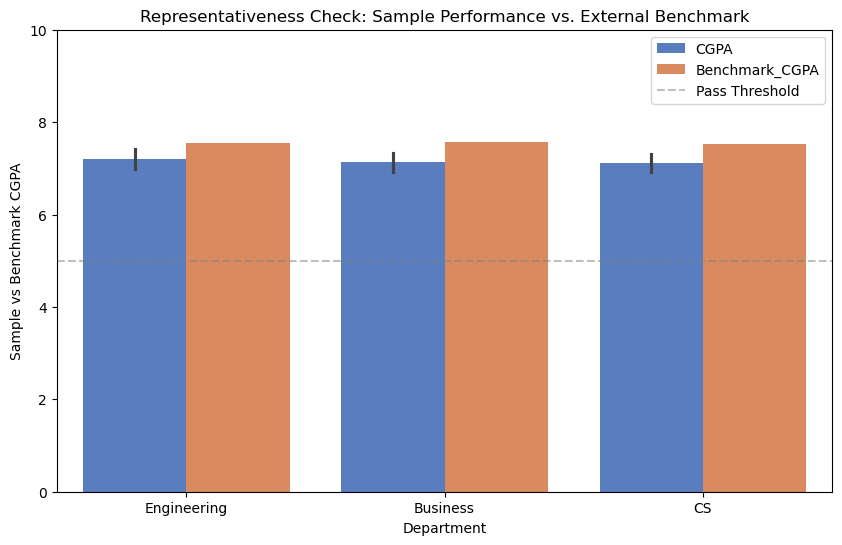

In [10]:
merged_df['Gap'] = merged_df['CGPA'] - merged_df['Benchmark_CGPA']

# Melt the data for side-by-side plotting
df_melted = merged_df.melt(id_vars='Department', 
                               value_vars=['CGPA', 'Benchmark_CGPA'], 
                               var_name='Source', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Department', y='Score', hue='Source', data=df_melted, palette='muted')

plt.axhline(y=5, color='gray', linestyle='--', alpha=0.5, label='Pass Threshold')

plt.title('Representativeness Check: Sample Performance vs. External Benchmark')
plt.ylabel('Sample vs Benchmark CGPA')
plt.ylim(0, 10)
plt.legend()
plt.show()

## 3. Summary Statistics
In this section, we compute key statistical measures for the main variables of interest: academic performance (CGPA), AI tool usage habits, and aptitude scores. These metrics include the mean, median, minimum, maximum, standard deviation, and skewness to understand the data's central tendency and spread.

**Insights from the Summary Statistics:**

- Academic Performance (CGPA): The CGPA distribution is negatively skewed (-0.63), with the median (7.36) being higher than the mean (7.15). This indicates that the majority of students are performing relatively well (clustering toward higher grades), while a smaller "tail" of lower performing students is pulling the average down.

- Total AI Time (Significant Skew): This variable shows the most dramatic distribution behavior. It has a high positive skew (2.01) and a standard deviation (496.10) that exceeds its mean (378.70). The mean is more than double the median (174.00), suggesting that "average" AI time is heavily inflated by a small group of "power users" (one student reached 2300 minutes). For most statistical analyses, the median is a more representative figure here than the mean.

- Usage Frequency & Duration: Both usage frequency and session duration show moderate positive skewness (0.76 and 0.67 respectively). This confirms a pattern where most students use the tool moderately (around 6 times a week for ~42 minutes), but there is a consistent subset of students who use it much more intensively.

- Aptitude Score Stability: The aptitude scores are the most symmetrical of the variables (skewness of -0.21, close to 0). With a mean of 3.60 and a median of 4.00, this suggests a fairly balanced distribution of innate ability across your sample, unlike the highly skewed AI usage habits.

In [23]:
cols_of_interest = [
    'CGPA', 
    'ChatGPT_Usage_Frequency_Per_Week', 
    'Average_Session_Duration_Minutes', 
    'Total_AI_Time', 
    'Aptitude_Score'
]

summary_stats = merged_df[cols_of_interest].agg(['mean', 'median', 'min', 'max', 'std']).T

summary_stats.columns = ['Mean', 'Median', 'Min', 'Max', 'Standard Deviation']

summary_stats['Skewness'] = merged_df[cols_of_interest].skew()
print(summary_stats)

                                        Mean  Median   Min     Max  \
CGPA                                7.145865    7.36  5.02     8.5   
ChatGPT_Usage_Frequency_Per_Week    7.236287    6.00  1.00    20.0   
Average_Session_Duration_Minutes   46.742616   42.00  1.00   119.0   
Total_AI_Time                     378.704641  174.00  1.00  2300.0   
Aptitude_Score                      3.599156    4.00  0.00     8.0   

                                  Standard Deviation  Skewness  
CGPA                                        0.933698 -0.625474  
ChatGPT_Usage_Frequency_Per_Week            5.622582  0.756495  
Average_Session_Duration_Minutes           32.423397  0.668425  
Total_AI_Time                             496.096924  2.013118  
Aptitude_Score                              2.443358 -0.210774  


## 4. Correlation Analysis
This section presents a correlation matrix that quantifies the linear relationships between various student performance and AI usage indicators. A correlation value close to 1 or -1 indicates a strong positive or negative relationship, respectively, while values near 0 indicate weak or no correlation.

**Key Observations from the Heatmap:**
- CGPA and AI Usage: CGPA displays a moderate negative correlation with all AI usage metrics, specifically ChatGPT_Usage_Frequency_Per_Week (-0.37) and Total_AI_Time (-0.36). This suggests that higher frequency and longer duration of ChatGPT usage are associated with lower academic performance.

- The Role of Aptitude: Aptitude_Score is strongly positively correlated with CGPA (0.80), but strongly negatively correlated with ChatGPT_Usage_Frequency_Per_Week (-0.61). This indicates that students with lower underlying aptitude scores tend to use ChatGPT significantly more often, possibly relying on it as a compensatory tool.

- Departmental Dynamics: There is a striking near-perfect negative correlation (-0.98) between Benchmark_CGPA  and Avg_Stress_Level_Dept. This implies an inverse relationship where departments rated as "more difficult" are associated with lower reported stress levels (or vice versa), which may require checking how these specific metrics were scaled or defined.

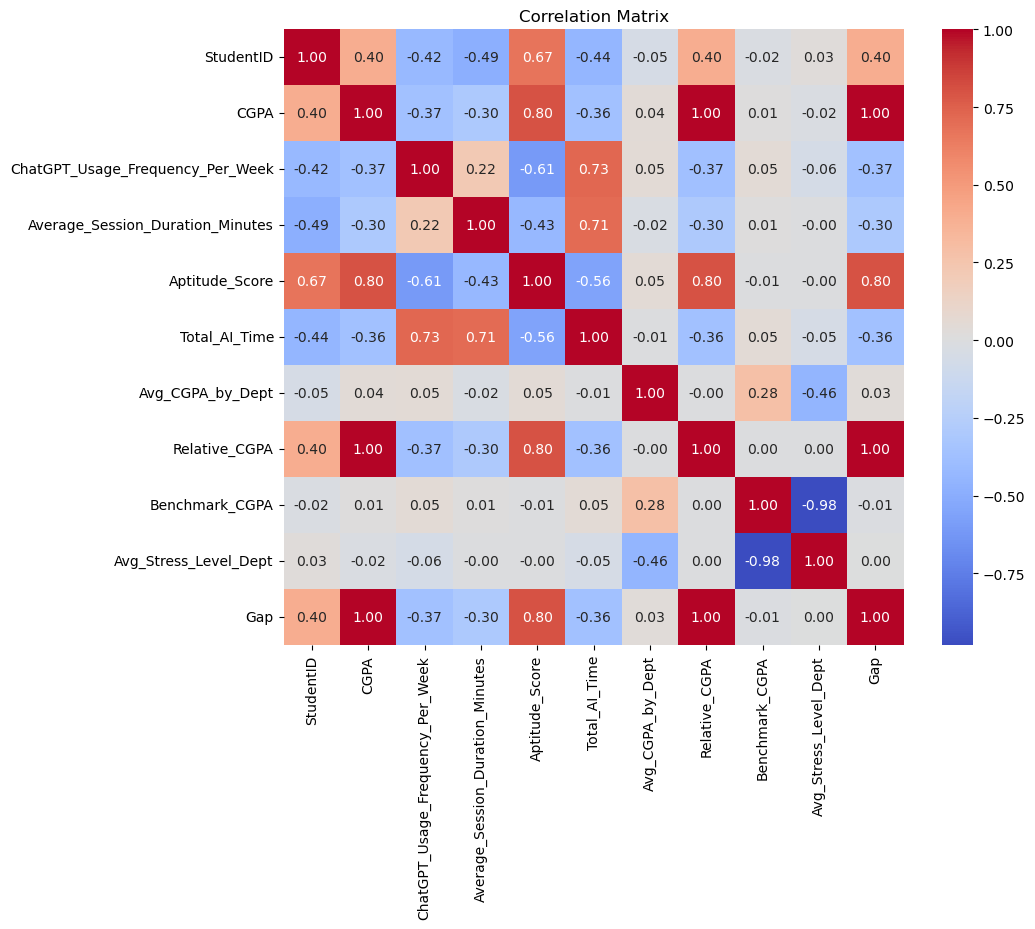

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## 5. Visualization

### Distribution of AI Usage by students and Students' CGPA

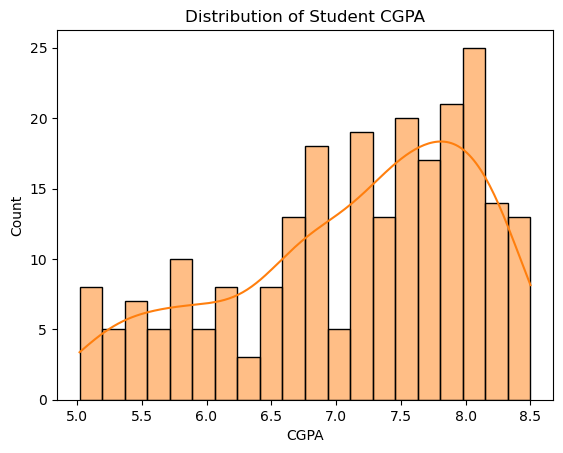

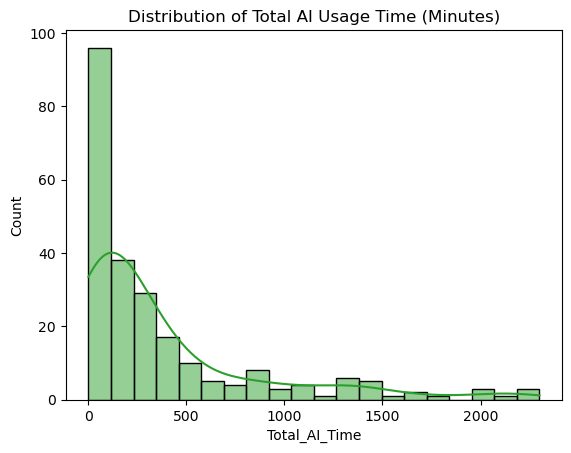

In [13]:
sns.histplot(data=merged_df['CGPA'],bins=20, kde=True, color='C1')
plt.title("Distribution of Student CGPA")
plt.show()

sns.histplot(data=merged_df['Total_AI_Time'],bins=20, kde=True, color='C2')
plt.title("Distribution of Total AI Usage Time (Minutes)")
plt.show()

### Relation Between AI Usage and Academic Performance
This scatterplot with a regression line visualizes the core hypothesis of the study: does spending more time with AI tools correlate with better grades? The x-axis represents the total time spent using AI tools, while the y-axis represents the student's CGPA.

Key Observations:

- Negative Trend: The regression line shows a clear downward slope. As Total_AI_Time increases, CGPA tends to decrease. This visually confirms the negative correlation (-0.36) observed in the statistical summary.

- Cluster of High Performers: Students with the highest CGPAs generally cluster in the lower-to-moderate range of AI usage.

- Outliers: Those with extremely high AI time mostly fall into the lower half of the CGPA spectrum, suggesting that excessive reliance might be bad or indicative of struggling students seeking help.

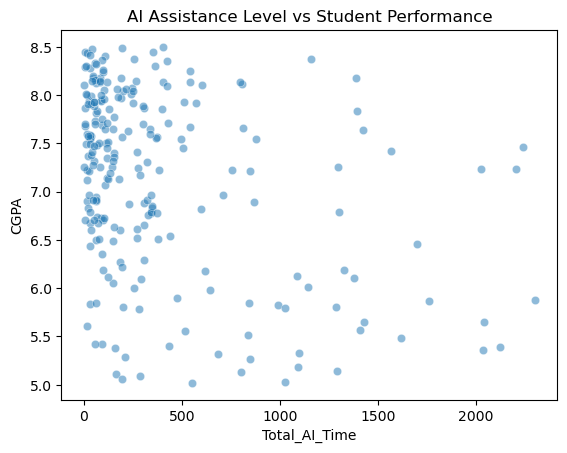

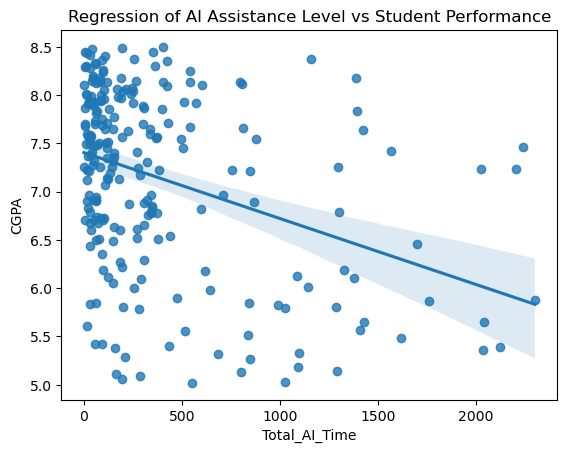

In [14]:
sns.scatterplot(data=merged_df, x="Total_AI_Time", y="CGPA", alpha=0.5)
plt.title("AI Assistance Level vs Student Performance")
plt.show()

sns.regplot(data=merged_df, x="Total_AI_Time", y="CGPA")
plt.title("Regression of AI Assistance Level vs Student Performance")
plt.show()

By dividing the scatterplot by departments, we can see if the general negative trend between AI Usage time and CGPA is the same for all departments. This is to avoid any departments overshadowing other departments that have different trends and creating a false conclusion.

**Key Observation:**
- Consistent Negative Trend: This confirms that the negative correlation between AI usage time and CGPA is a robust finding and not caused by one specific department skewing the data.
- Strength of the Relationship: The slope appears slightly steeper for CS (Computer Science) and Engineering compared to Business. This might suggest that in technical fields, where problem-solving and coding require deep individual practice, outsourcing work to AI has a more immediate negative impact on performance metrics (CGPA) than in Business, where tasks might be more qualitative.

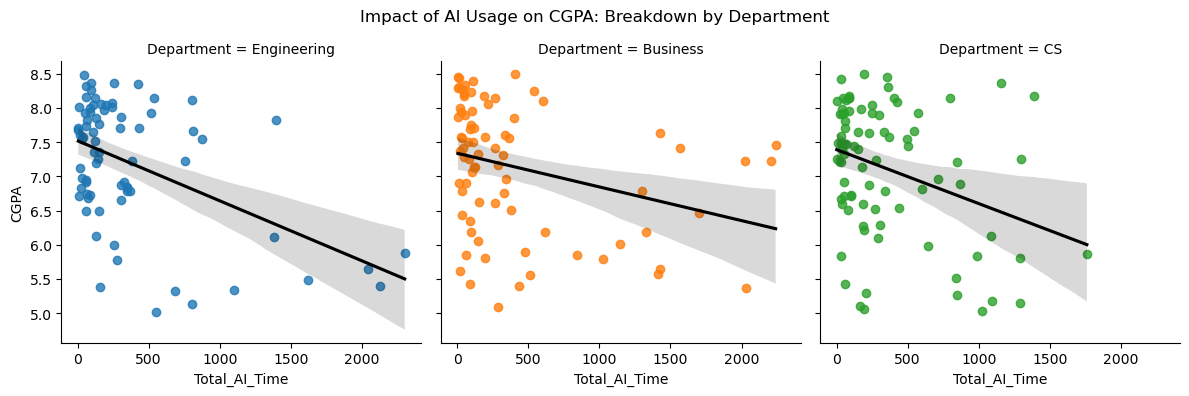

In [15]:
# Check if the negative trend is consistent across all majors
g = sns.lmplot(
    data=merged_df, 
    x="Total_AI_Time", 
    y="CGPA", 
    col="Department", # Creates a separate chart for each dept
    hue="Department", 
    height=4, 
    aspect=1,
    line_kws={'color': 'black'} # Makes the trend line distinct
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Impact of AI Usage on CGPA: Breakdown by Department')
plt.show()

### Relation between Aptitude and Frequency of AI usage
This regression explores the "compensatory hypothesis", the idea that students might use AI tools to bridge a gap in fundamental understanding or aptitude. We map the Aptitude_Score against how frequently a student consults ChatGPT per week as well as Aptitude_Score against Student CGPA.



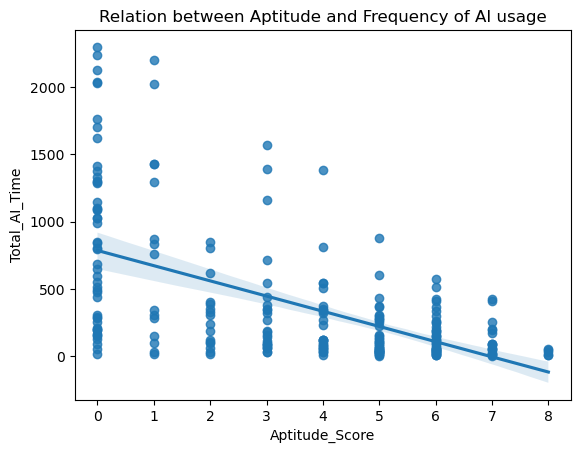

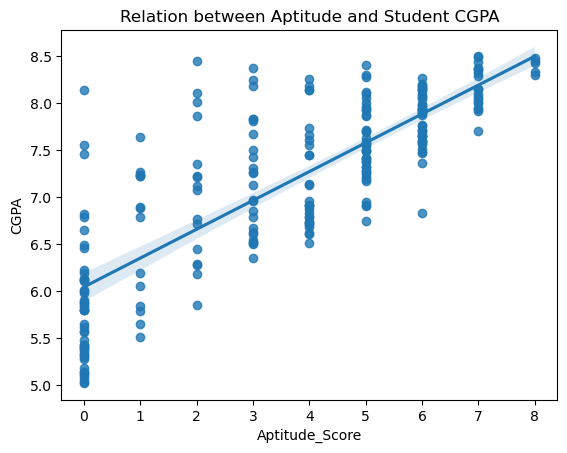

In [16]:
# Aptitude vs AI Usage and CGPA

sns.regplot(data=merged_df, x="Aptitude_Score", y="Total_AI_Time")
plt.title("Relation between Aptitude and Frequency of AI usage")
plt.show()

sns.regplot(data=merged_df, x="Aptitude_Score", y="CGPA")
plt.title("Relation between Aptitude and Student CGPA")
plt.show()

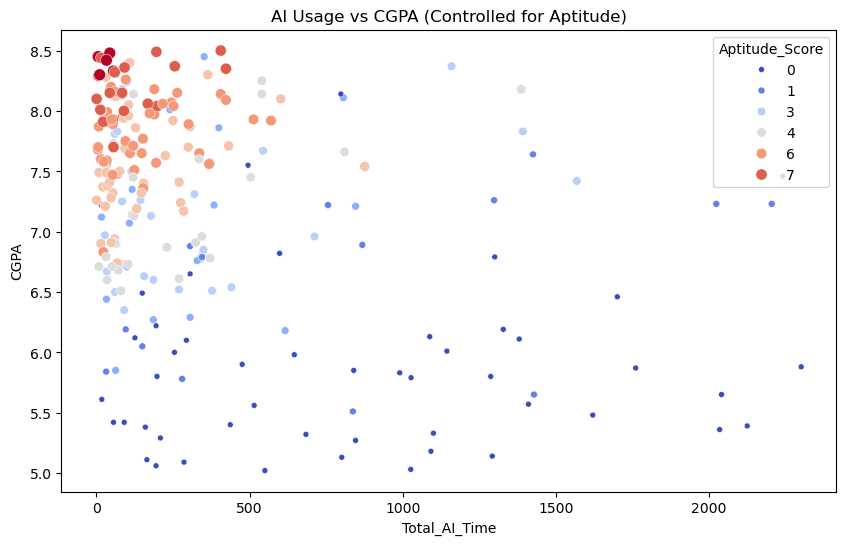

In [17]:
# Multivariate scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="Total_AI_Time", y="CGPA", hue="Aptitude_Score", palette="coolwarm", size="Aptitude_Score")
plt.title("AI Usage vs CGPA (Controlled for Aptitude)")
plt.show()

### Relation between Relative CGPA and Total AI Time
Relative CGPA allows us to see regardless of the student's field of study, are they considered as "Overachiever" which have CGPA above their department's AVG CGPA or "Underachiever" which have CGPA lower than their department's AVG CGPA

**Key Observations from the Boxplot:**
- Higher Median Usage for "Below Average" Students: This indicates that the typical student who is underperforming relative to their peers spends roughly 2x to 3x more time using AI tools than their high-performing counterparts.
- Variability in Usage Habits: The orange box is much taller than the green box. This means there is a wider variation in behavior among lower-performing students, some use it a little, but many use it heavily. In contrast, the high-performing group (green) is more consistent, the vast majority cluster in the low-usage range.
- The "Normal" Range vs. Outliers: Analyse the whisker of both groups.

    - For Above Average (Green) students, standard usage maxes out around 750 minutes. Anything above that is considered a statistical outlier.

    - For Below Average (Orange) students, standard usage extends all the way up to around 1750 minutes.

    Insight: Heavy AI reliance is a "standard" behavior pattern for the lower-performing group, whereas it is an anomaly for the high-performing group.

Average AI Time by Performance Group:
  Performance_Group  Total_AI_Time
0    Above Dept Avg     284.266187
1    Below Dept Avg     512.653061


C:\Users\user\AppData\Local\Temp\ipykernel_5264\1144802021.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Performance_Group', y='Total_AI_Time', data=merged_df, palette='viridis', ci=None)
C:\Users\user\AppData\Local\Temp\ipykernel_5264\1144802021.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Performance_Group', y='Total_AI_Time', data=merged_df, palette='viridis', ci=None)


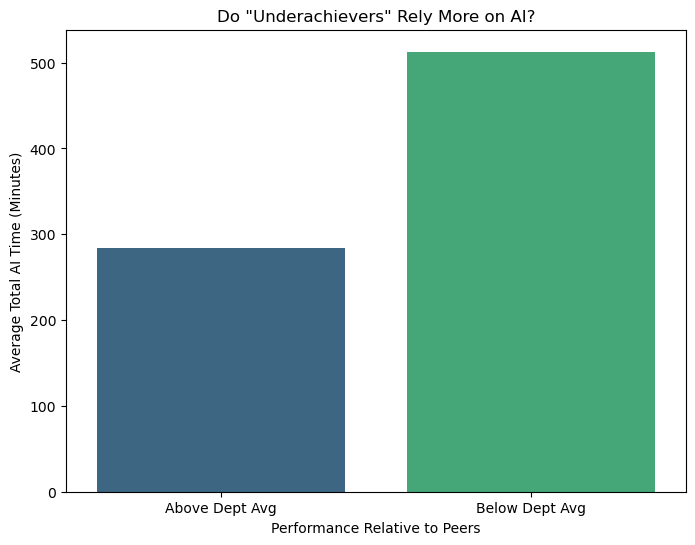

C:\Users\user\AppData\Local\Temp\ipykernel_5264\1144802021.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Performance_Group', y='Total_AI_Time', data=merged_df, palette='Set2')


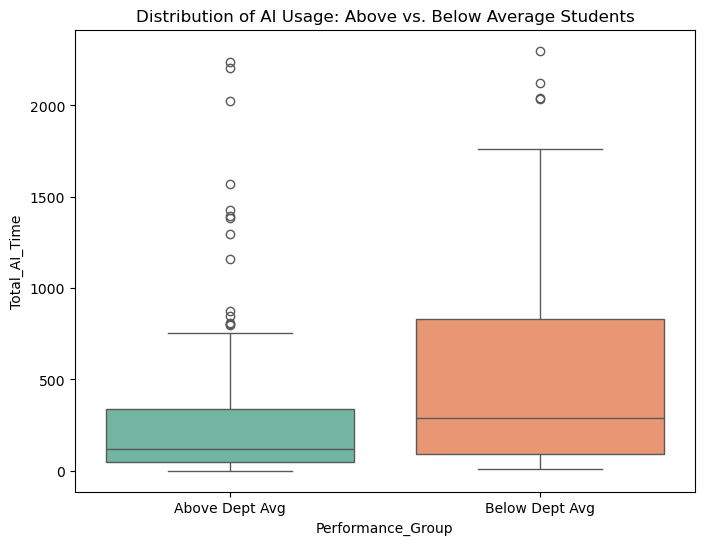

In [18]:
# 1. Create a Category based on Relative CGPA
merged_df['Performance_Group'] = merged_df['Relative_CGPA'].apply(lambda x: 'Above Dept Avg' if x > 0 else 'Below Dept Avg')

# 2. Calculate Mean AI Time for each group
group_stats = merged_df.groupby('Performance_Group')['Total_AI_Time'].mean().reset_index()
print("Average AI Time by Performance Group:")
print(group_stats)

# 3. Visualize difference
plt.figure(figsize=(8, 6))
sns.barplot(x='Performance_Group', y='Total_AI_Time', data=merged_df, palette='viridis', ci=None)

plt.title('Do "Underachievers" Rely More on AI?')
plt.xlabel('Performance Relative to Peers')
plt.ylabel('Average Total AI Time (Minutes)')
plt.show()

# Optional: Boxplot to see the spread (and catch those 2300 min outliers)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Performance_Group', y='Total_AI_Time', data=merged_df, palette='Set2')
plt.title('Distribution of AI Usage: Above vs. Below Average Students')
plt.show()

### Relation between Reason for AI usage and CGPA

The violin plot supports the idea that intent matters. Using AI for efficiency ("saves time") aligns with the highest academic performance, while using it without clear direction ("no idea") is associated with the most volatile and often lower academic results. 

**Key Observations from the Violin Plot:**

- Highest Performers ("Saves Time"): The blue distribution on the left ("saves time") is noticeably "top-heavy." The bulk of the data (the widest part of the violin) is concentrated in the higher CGPA range, roughly between 7.5 and 8.5. This suggests that students who use AI as a productivity tool tend to be higher achievers.

- Inconsistent Performance ("No Idea"): The orange distribution in the middle ("no idea") shows a distinct bimodal pattern (two bulges). There is a group performing well (around 8.0) and another group performing significantly lower (around 6.0). This indicates that students who lack a clear purpose for using AI are either high performers experimenting with it or struggling students using it without a strategy. The lack of intent correlates with less consistent outcomes.

- Quality Improvement ("Better Answers"): The green distribution on the right ("better answers") is fairly balanced but leans slightly lower than the "saves time" group. The median (middle dashed line) is lower than the blue group's median. This implies that students relying on AI to improve the content of their answers (perhaps due to a lack of confidence or knowledge) achieve decent grades but generally do not reach the same high-performance peak as those using it purely for efficiency.



C:\Users\user\AppData\Local\Temp\ipykernel_5264\2820226538.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


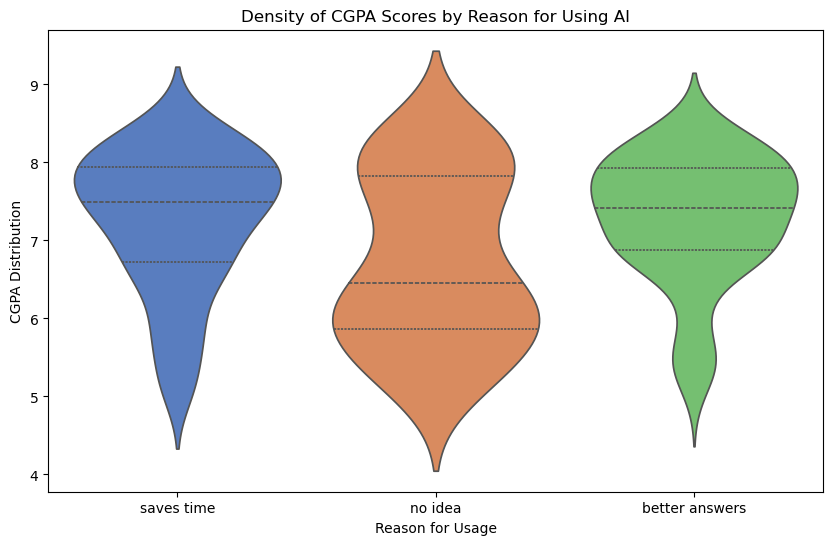

In [19]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='Reason_For_Using_ChatGPT', 
    y='CGPA', 
    data=merged_df, 
    palette='muted',
    inner='quartile' # Draws lines for the 25th, 50th, and 75th percentiles inside
)
plt.title('Density of CGPA Scores by Reason for Using AI')
plt.xlabel('Reason for Usage')
plt.ylabel('CGPA Distribution')
plt.show()

### Relation between Reason for AI Usage and Aptitude score

This section will show us is there any correlation student's aptitude score and their reason for using AI Assistance. It will also reflect whether their reason is due to academic struggles or purely to streamline their workflow.

**Key Observations:**
- Both the "saves time" and "better answers" groups have higher median Aptitude Scores (around 4 to 5) compared to the "no idea" group. This suggests that students with higher aptitude tend to use AI with a specific purpose in mind, whether it's for efficiency or quality improvement.
- The "no idea" group has a significantly lower median score (around 0 to 1) and a distribution heavily skewed towards the lower end of the aptitude scale (the box sits at the bottom). This reinforces the idea that students who lack a clear strategy for using AI are often those with lower fundamental aptitude, possibly indicating a lack of engagement or understanding of how to leverage the tool effectively.

C:\Users\user\AppData\Local\Temp\ipykernel_5264\2486166050.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="Reason_For_Using_ChatGPT", y="Aptitude_Score", palette="Set2")


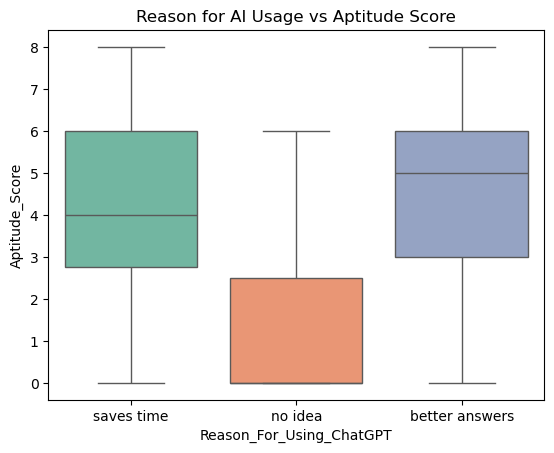

In [20]:
# Satisfaction vs GPA
sns.boxplot(data=merged_df, x="Reason_For_Using_ChatGPT", y="Aptitude_Score", palette="Set2")
plt.title("Reason for AI Usage vs Aptitude Score")
plt.show()

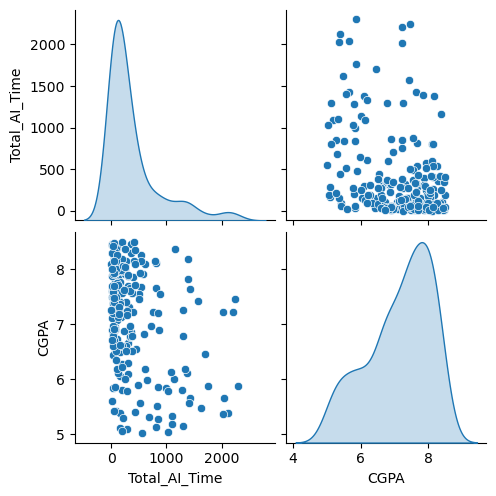

In [21]:
sns.pairplot(merged_df[['Total_AI_Time','CGPA']], diag_kind='kde')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_5264\348345836.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


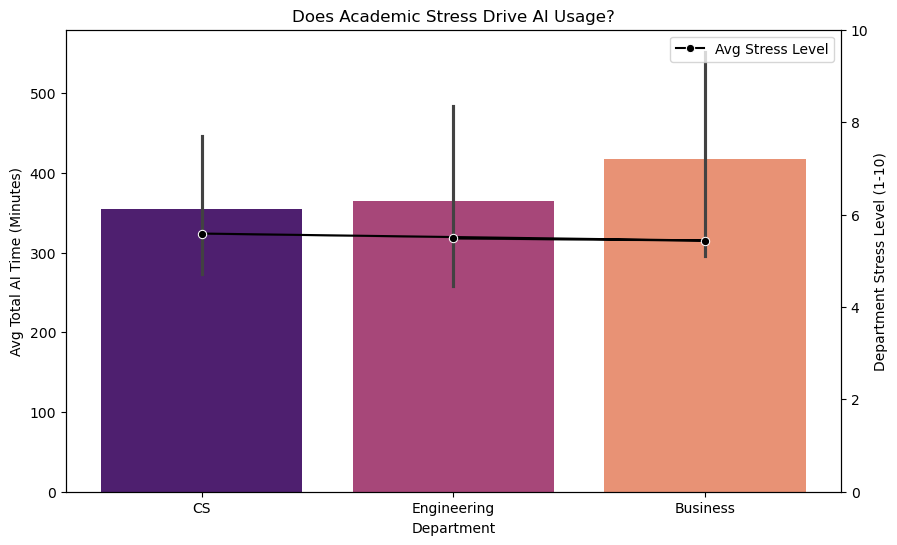

In [22]:
# 1. Sort departments by Stress Level
stress_order = merged_df.sort_values('Avg_Stress_Level_Dept', ascending=False)['Department'].unique()

plt.figure(figsize=(10, 6))

# 2. Plot Average AI Time per Dept
ax = sns.barplot(
    data=merged_df, 
    x='Department', 
    y='Total_AI_Time', 
    order=stress_order, 
    palette='magma'
)

# 3. Add a secondary axis to show the stress level line
ax2 = ax.twinx()
sns.lineplot(
    data=merged_df, 
    x='Department', 
    y='Avg_Stress_Level_Dept', 
    color='black', 
    marker='o', 
    ax=ax2, 
    label='Avg Stress Level',
    sort=False # Prevent resorting, keep barplot order
)

ax.set_title('Does Academic Stress Drive AI Usage?')
ax.set_ylabel('Avg Total AI Time (Minutes)')
ax2.set_ylabel('Department Stress Level (1-10)')
ax2.set_ylim(0, 10)
plt.show()

## 6. Summary of Exploratory Data Analysis (EDA)
This exploratory data analysis investigated the relationship between generative AI usage habits (specifically ChatGPT) and academic performance (CGPA) among university students. By enriching survey data with derived performance metrics and external departmental benchmarks, we were able to isolate the impact of AI reliance from departmental grading variations.

**Data Cleaning and Feature Engineering:**
- Logical Correction: Addressed inconsistencies where usage frequency did not align with session duration (e.g., 0 frequency but positive duration).

- Metric Creation: Calculated Total_AI_Time to measure overall intensity and Relative_CGPA to normalize student performance against their specific department's average.

- External Enrichment: Integrated external grading standards to contextualize the sample’s performance against the broader university population.

**Descriptive Statistics:**

- Performance: The sample showed a slightly negative skew in CGPA (Mean ~7.15), indicating a generally passing but not elite student body (performing slightly below external benchmarks).

- Usage Skew: AI usage data was highly positively skewed (Skewness > 2.0). The mean usage time was significantly higher than the median, driven by a small subset of "power users," while the majority of students demonstrated moderate usage.

**Correlation Analysis:**

- Negative Associations: The correlation matrix revealed a moderate negative relationship between all AI usage metrics (Time and Frequency) and Academic Performance (CGPA).

- The Aptitude Factor: There was a strong negative correlation between Aptitude_Score and AI usage. This suggests that students with lower fundamental domain knowledge are the ones relying most heavily on the tool, supporting the performance compensatory theory.

**Visualizations:**

- Trend Consistency: Department-separated scatterplots confirmed that the negative correlation between AI time and CGPA holds true across all departments (CS, Engineering, Business), ensuring that the trend is not an artifact of specific major difficulty.

- Compensatory Behavior: Boxplots based on Relative_CGPA showed that "Underachievers" (those performing below their peers) spend roughly 2x to 3x more time using AI tools than "Overachievers."

- Intent vs. Outcome: Violin plots highlighted that why a student uses AI matters. Students using it strategically to "Save Time" achieved the highest grades, while those using it to generate "Better Answers" or with "No Idea" of its purpose clustered at the lower end of the grade spectrum.

**Conclusion:** \
The EDA suggests that for this specific population, heavy AI usage is not a driver of high performance, but rather a coping mechanism for struggling students. The data indicates that high achievers use the tool sparingly for efficiency, while lower achievers rely on it heavily to bridge aptitude gaps.